## Advanced Lane Finding Project

### Write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car.

(1) Camera calibration using 9 x 6 chessboard images. (camera matrix & distortion coefficients)  
(2) Convert original imagel to undistorted image using camera matrix and distortion coeffiencts.   
(3) Apply perspective transformation (M) to get bird view warped image. (input: undistort image, output: warped image)   
(4) Create binary image using various combinations of color and gradient thresholds on warped images. (Sobel Operator)  
(5) Find lanes on the binary images. (identify lane line pixels)  
(6) Implement sliding windows and fit a polynomial.  
(7) Measure lane curvature.  
(8) Lane prediction and drawing.  


### Camera Calibration and Undistorted Image

There are 17 images being used for camera calibration!


True

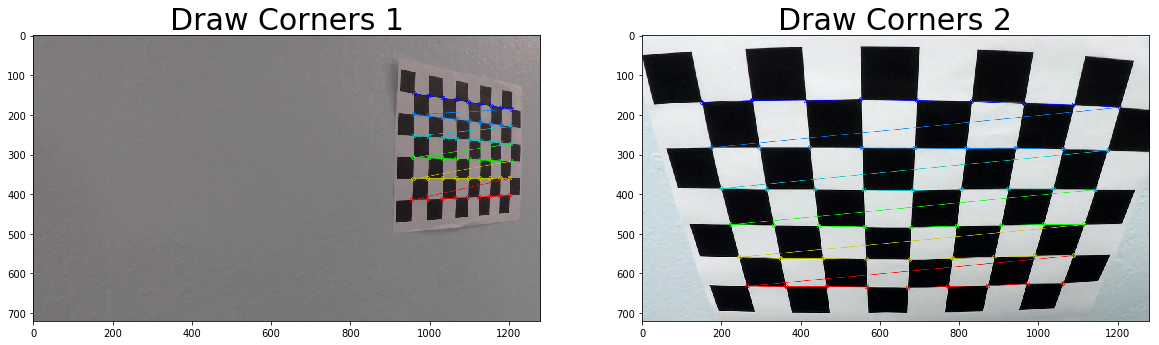

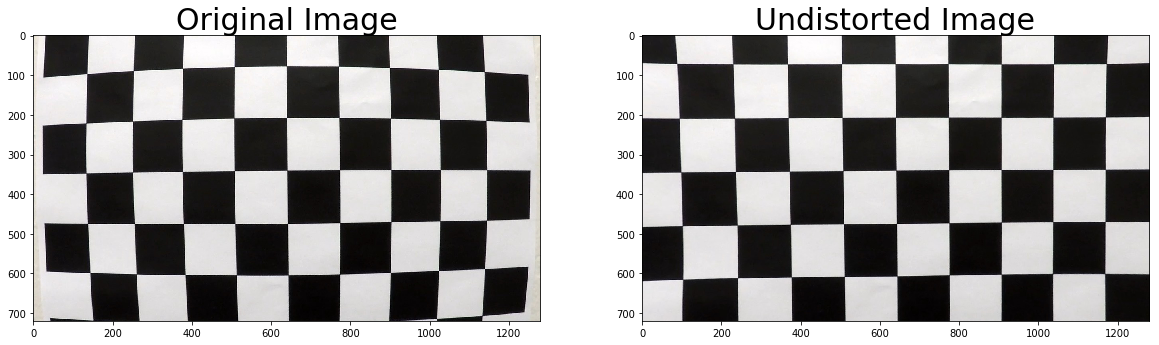

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline

"""
Code Reference: Lesson 16 - Camera Calibration

"""

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# processed images
processed_images = []

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        processed_images.append(img)

print("There are %d images being used for camera calibration!" % len(processed_images))

# Visualization
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(processed_images[4])
ax1.set_title('Draw Corners 1', fontsize=30)
ax2.imshow(processed_images[10])
ax2.set_title('Draw Corners 2', fontsize=30)

# cv2.imwrite() only save image with BGR format
save_img_1 = cv2.cvtColor(processed_images[4],cv2.COLOR_RGB2BGR)
save_img_2 = cv2.cvtColor(processed_images[10],cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/draw_chessboard_1.jpg', save_img_1)
cv2.imwrite('output_images/draw_chessboard_2.jpg', save_img_2)

# Calibrate, calculate distortion coefficients, and test undistortion on images

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

dst = cv2.cvtColor(dst,cv2.COLOR_RGB2BGR)
# cv2.imwrite() only save image with BGR format
cv2.imwrite('output_images/undistort_chessboard.jpg', dst)

img_save = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/original_chessboard.jpg', img_save)


### Bird-view Perspective Transformation

True

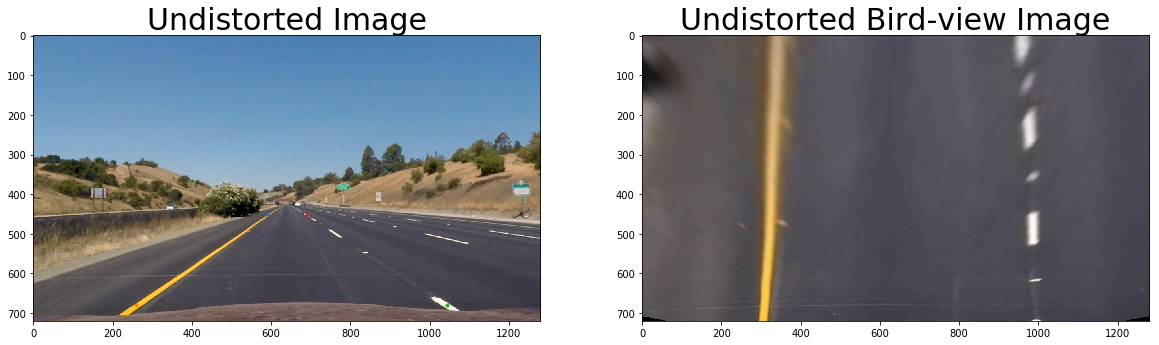

In [2]:
"""
Code Reference: Lesson 16 - Undistort and Perspective Transform

"""
# input image is RGB format
# output image: undistorted bird-view image
def undistort_birdview(img, mtx, dist):
    
    # Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    img_size = (undist.shape[1], undist.shape[0])
    
    # four points define a rectangle in the input image
    src = np.float32([[590, 450], 
                      [260, 680], 
                      [1045, 680], 
                      [690, 450]])
    
    # position on the output image
    dst = np.float32([[300, 0], 
                      [300, 720], 
                      [1000, 720], 
                      [1000, 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, M_inv

# read image in RGB format
test_img = mpimg.imread('test_images/straight_lines1.jpg')
test_img = cv2.undistort(test_img, mtx, dist, None, mtx)
birdview_img, M, M_inv = undistort_birdview(test_img, mtx, dist)

# Visualization
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.plot(590, 450, '.')  # top right point of the rectangle
ax1.plot(260, 680, '.')  # bottom right point of the rectangle
ax1.plot(1045, 680, '.') # bottom left point of the rectangle
ax1.plot(690, 450, '.')  # top left point of the rectangle
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(birdview_img)
ax2.set_title('Undistorted Bird-view Image', fontsize=30)

birdview_save = cv2.cvtColor(birdview_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/undistort_birdview.jpg', birdview_save)

undistort_save = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
cv2.imwrite('output_images/undistort.jpg', undistort_save)


### Binary Image for Lane Line Detection

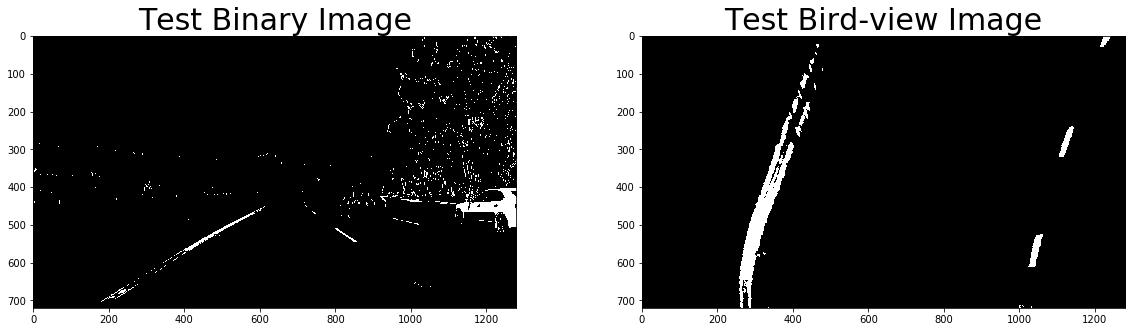

In [3]:
"""
Code Reference: Lesson 17 - Combining Threshold

"""

def pipeline(image, s_thresh=(50, 255), r_thresh=(220, 255), sx_thresh=(30, 255), sobel_kernel=5):
    
    r_channel = image[:,:,0]
    
    #print(r_channel.shape)
    #print(np.max(r_channel))
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    
    # Stack each channel
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(r_binary == 1) | (sxbinary == 1) & (s_binary == 1) ] = 1
    
    # | (s_binary == 1)
    
    return combined_binary


# read image in RGB format
test_img = mpimg.imread('test_images/test8.jpg')
test_img = cv2.undistort(test_img, mtx, dist, None, mtx)
#print(test_img.shape)
#print(np.max(test_img))
birdview_img, M, M_inv = undistort_birdview(test_img, mtx, dist)

test_binary = pipeline(test_img)
birdview_binary = pipeline(birdview_img)

# Visualization
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.imshow(test_binary, cmap='gray')
ax1.set_title('Test Binary Image', fontsize=30)
ax2.imshow(birdview_binary, cmap='gray')
ax2.set_title('Test Bird-view Image', fontsize=30)

birdview_binary_save = np.copy(birdview_binary)
# print(type(birdview_binary_save))
mpimg.imsave('output_images/test_birdview_binary.jpg', birdview_binary_save, cmap='gray')
mpimg.imsave('output_images/test_binary.jpg', test_binary, cmap='gray')


### Advanced Lane Findings

(720, 1280)


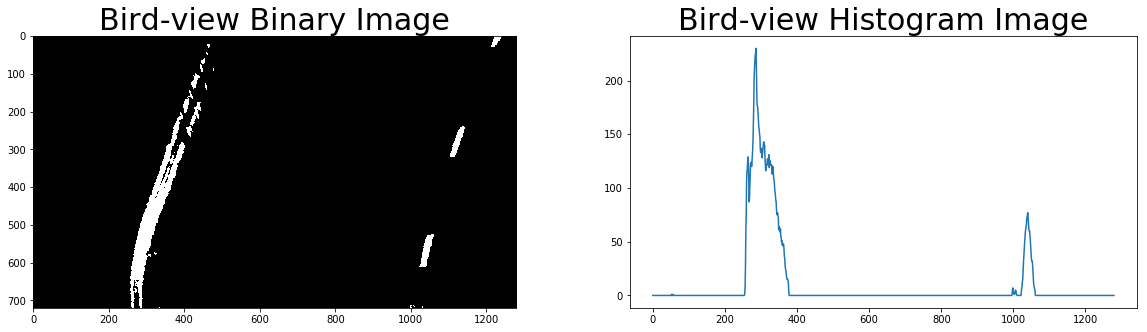

In [4]:
# Line Finding Method: Peaks in a Histogram
# birdview_binary.jpg

"""
Code Reference: Lesson 18 - Finding the Lines: Histogram Peaks

"""

def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    return histogram

birdview_binary = mpimg.imread('output_images/test_birdview_binary.jpg')
birdview_binary = cv2.cvtColor(birdview_binary, cv2.COLOR_RGB2GRAY)
birdview_binary[birdview_binary >= 255] = 1
print(birdview_binary.shape)
birdview_hist = hist(birdview_binary)

# Visualization
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.imshow(birdview_binary, cmap='gray')
ax1.set_title('Bird-view Binary Image', fontsize=30)
ax2.plot(birdview_hist)
ax2.set_title('Bird-view Histogram Image', fontsize=30)


The left fit is: [0.00017491071185662732, -0.45250871381938662, 491.65479811215937]
The right fit is: [0.00015324525451362056, -0.41287612250033678, 1225.1207375656816]


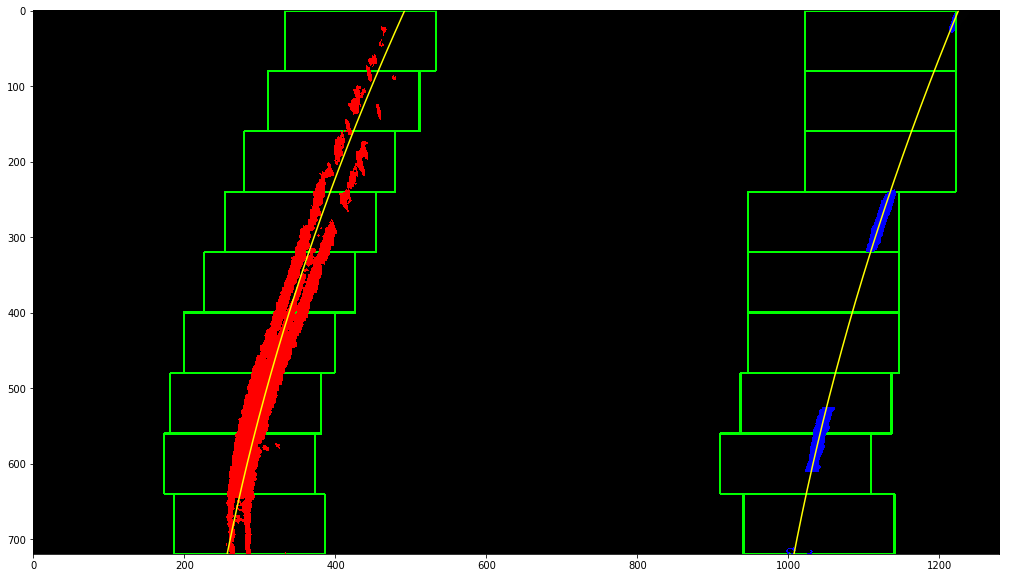

In [5]:
"""
Code Reference: Lesson 18 - Finding the Lines: Sliding Window

"""
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

binary_warped = mpimg.imread('output_images/test_birdview_binary.jpg')
binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2GRAY)
binary_warped[binary_warped >= 255] = 1

def find_lane_pixels(binary_warped):
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    
    # Choose the number of sliding windows
    nwindows = 9
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    print("The left fit is: " + str(list(left_fit)) )
    print("The right fit is: " + str(list(right_fit)) )

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.figure(figsize=(20,10))
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

out_img = fit_polynomial(binary_warped)

plt.imshow(out_img)



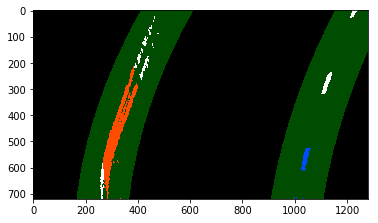

In [6]:
"""
Code Reference: Lesson 18 - Skip the sliding windows step once found the lines

"""

# left_lane_inds and right_lane_inds are used to hold the pixel values contained within 
# the boundaries of a given sliding window.

# Load our image - this should be a new frame since last time!
binary_warped = mpimg.imread('output_images/test_birdview_binary.jpg')
binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2GRAY)
binary_warped[binary_warped >= 255] = 1

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([-0.00040095548921610403, 0.54312285840853403, 187.24690007711249])
right_fit = np.array([-0.00060043357214953829, 0.72555329646613909, 810.32106916102362])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty


def search_around_poly(binary_warped):
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.figure(figsize=(20,10))
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    ## End visualization steps ##
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped)

# View your output
plt.imshow(result)


## Measuring Curvature

In [7]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# input: undistorted warped bird view binary image
# ouput: params for lanes' curvature calculation
def fit_poly_curvature(binary_warped):
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    image_shape = binary_warped.shape

    return image_shape, ploty, left_fit, right_fit, left_fitx, right_fitx

def measure_curvature_real(image_shape, ploty, left_fit, right_fit, left_fitx, right_fitx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # print(image_shape)
    img_height, img_width = image_shape[0], image_shape[1]
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/840 # meters per pixel in x dimension
    
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    car_center = xm_per_pix*(img_width/2)
    lane_center = xm_per_pix*((right_fitx[-1]+left_fitx[-1])/2)
    offset = lane_center - car_center
      
    return left_curverad, right_curverad, offset


# Load our image - this should be a new frame since last time!
binary_warped = mpimg.imread('output_images/test_birdview_binary.jpg')
binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2GRAY)
binary_warped[binary_warped >= 255] = 1
# print("The shape of the image is: %s" % str(binary_warped.shape))

# input image: undistorted warped bird-view binary image
curvature_params = fit_poly_curvature(binary_warped)

# output: left lane curvature, right lane curvature, 
left_curverad, right_curverad, offset = measure_curvature_real(curvature_params[0], curvature_params[1], 
                                                               curvature_params[2], curvature_params[3], 
                                                               curvature_params[4], curvature_params[5])

print(left_curverad, right_curverad)
print(offset)



1127.46403871 1286.79035026
-0.0347807160057


The shape of undistorted image is: (720, 1280, 3)
The shape of undistorted bird-view image is: (720, 1280, 3)
The shape of undistorted bird-view binary image is: (720, 1280)


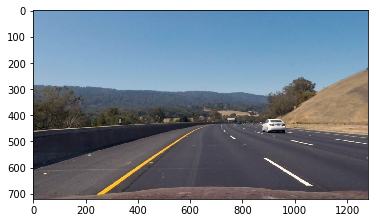

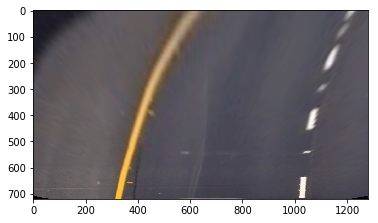

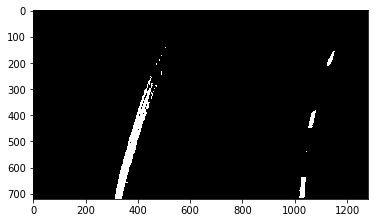

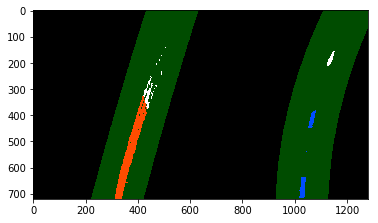

In [8]:
def drawing(undist, warped, ploty, left_fitx, right_fitx, M_inv):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (warped.shape[1], warped.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

##############################################################

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib qt
%matplotlib inline

# Test undistortion on an image
test_img = mpimg.imread('test_images/test3.jpg')
test_img_size = (test_img.shape[1], test_img.shape[0])

# Do camera calibration given object points and image points
# ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, test_img_size, None, None)
undist_test_img = cv2.undistort(test_img, mtx, dist, None, mtx)

plt.figure(1)
plt.imshow(undist_test_img)
print("The shape of undistorted image is: %s" % str(undist_test_img.shape))

# input: raw image in RGB format, mtx, dist
# output: undistorted bird-view image, M, M_inv
undist_birdview_test_img, M, M_inv = undistort_birdview(test_img, mtx, dist)
plt.figure(2)
plt.imshow(undist_birdview_test_img)
print("The shape of undistorted bird-view image is: %s" % str(undist_birdview_test_img.shape))

undist_birdview_binary_test_img = pipeline(undist_birdview_test_img)
plt.figure(3)
plt.imshow(undist_birdview_binary_test_img, cmap='gray')
print("The shape of undistorted bird-view binary image is: %s" % str(undist_birdview_binary_test_img.shape))


plt.figure(4)
result = search_around_poly(undist_birdview_binary_test_img)

# View your output
plt.imshow(result)

# curvature_params[0]: image_shape
# curvature_params[1]: ploty
# curvature_params[2]: left_fit
# curvature_params[3]: right_fit
# curvature_params[4]: left_fitx
# curvature_params[5]: right_fitx
# input: binary bird-view image
curvature_params = fit_poly_curvature(undist_birdview_binary_test_img)

# output: left lane curvature, right lane curvature, 
left_curverad, right_curverad, offset = measure_curvature_real(curvature_params[0], curvature_params[1], 
                                                               curvature_params[2], curvature_params[3], 
                                                               curvature_params[4], curvature_params[5])

result = drawing(undist_test_img, undist_birdview_binary_test_img, 
                 curvature_params[1], curvature_params[4], 
                 curvature_params[5], M_inv)



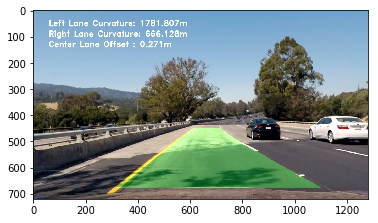

In [9]:
def pipline_prediction(raw_image):
    
    global mtx
    global dist
    
    undist_img = cv2.undistort(raw_image, mtx, dist, None, mtx)
    undist_birdview_img, M, M_inv = undistort_birdview(raw_image, mtx, dist)
    undist_birdview_binary_img = pipeline(undist_birdview_img)
    
    # curvature_params[0]: image_shape
    # curvature_params[1]: ploty
    # curvature_params[2]: left_fit
    # curvature_params[3]: right_fit
    # curvature_params[4]: left_fitx
    # curvature_params[5]: right_fitx
    # input: binary bird-view image
    curvature_params = fit_poly_curvature(undist_birdview_binary_img)
    
    left_curverad, right_curverad, offset = measure_curvature_real(undist_birdview_binary_img.shape,
                                                                   curvature_params[1],
                                                                   curvature_params[2],
                                                                   curvature_params[3],
                                                                   curvature_params[4],
                                                                   curvature_params[5])
    
    predict = drawing(undist_img, undist_birdview_binary_img, curvature_params[1], 
                     curvature_params[4], curvature_params[5], M_inv)
    
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(predict,'Left Lane Curvature: %.3fm' % (left_curverad), (60,60), font, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(predict,'Right Lane Curvature: %.3fm' % (right_curverad), (60,100), font, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(predict,'Center Lane Offset : %.3fm'%(offset),(60,140), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    return predict


predict_test_img = mpimg.imread('test_images/test4.jpg')
predict = pipline_prediction(predict_test_img)
plt.imshow(predict)

mpimg.imsave('output_images/lane_prediction.jpg', predict)
    

In [10]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipline_prediction) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:05<00:00,  6.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 3min 6s
